### Importing Packages and API Key

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from scipy import stats

# Load environment variables from the .env file
load_dotenv('../config.env')


True

In [2]:
# Import MlFinLab package
import mlfinlab
from mlfinlab.data_structures.standard_data_structures import (get_dollar_bars,
                                                               get_tick_bars, get_volume_bars)

from mlfinlab.multi_product.etf_trick import get_futures_roll_series
from mlfinlab.data_structures.imbalance_data_structures import get_ema_dollar_imbalance_bars


<frozen mlfinlab.util.fast_ewma>:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


### Importing Data and Creating Dollar Bars

In [3]:
# import ES_Trades data
path = '../Data/ES_Trades.csv'
data = pd.read_csv(path)

# viewing data
data.head()


,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
2,ESU13,09/01/2013,17:00:00.083,1640.25,2,E,0,NaN,1640.25
3,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
4,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25


In [4]:
# get all unique values of the 'Symbol' column

data['Symbol'].unique()

array(['ESU13', 'ESZ13'], dtype=object)

In [5]:
# Format the Data
date_time = data['Date'] + ' ' + data['Time'] # Dont convert to datetime here, it will take forever to convert.
new_data = pd.concat([date_time, data['Price'], data['Volume']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head())
print('\n')
print('Rows:', new_data.shape[0])


                      date    price  volume
0  09/01/2013 17:00:00.083  1640.25       8
1  09/01/2013 17:00:00.083  1640.25       1
2  09/01/2013 17:00:00.083  1640.25       2
3  09/01/2013 17:00:00.083  1640.25       1
4  09/01/2013 17:00:00.083  1640.25       1


Rows: 5454950


In [6]:
# 'new_data' can be simply replaced with the file path where 'raw_tick_data' was saved if memory is an issue
print('Creating Dollar Bars')
dollar = get_dollar_bars(new_data, threshold=70000000,
                         batch_size=1000000, verbose=True)


Creating Dollar Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 



### Confirming Sampling

In [7]:
# Confirm the dollar sampling
dollar['value'] = dollar['close'] * dollar['volume']
dollar.head()


,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,value
date_time,,,,,,,,,,
09/01/2013 21:34:39.298,11207,1640.25,1643.5,1639.00,1640.75,42862,21896,11207,70347610.00,70325826.5
09/02/2013 02:56:24.209,26547,1640.75,1646.0,1640.25,1644.50,42585,24320,15340,70000546.50,70031032.5
09/02/2013 06:37:33.128,40473,1644.50,1647.5,1644.25,1647.50,42580,23167,13926,70095794.25,70150550.0
09/02/2013 09:34:46.141,51328,1647.50,1648.5,1645.25,1647.00,42535,23904,10855,70053015.75,70055145.0
09/02/2013 22:55:20.297,64261,1647.00,1648.5,1645.25,1648.00,42512,23884,12933,70024910.50,70059776.0


### Creating a Continuous Futures Contract using the ETF Trick

In [8]:
# making a copy of  dollar and dollar_imbalance
dollar_roll = dollar.copy()

# Ensure the index is a datetime object for each of the dataframes
dollar_roll.index = pd.to_datetime(dollar_roll.index)

# adding a date column to dollar_roll, tick and volume bars
dollar_roll['date'] = dollar_roll.index.date

# selecting only the columns we need for the ETF trick: 'date', 'date_time', 'close', 'open', 'high', 'low', 'volume' for each dataframe
dollar_roll = dollar_roll[['date', 'close', 'open', 'high', 'low', 'volume']]

# adding a ticker column to dollar_roll with the value 'ES' for each dataframe from above
dollar_roll['ticker'] = 'ES'

# adding a nearest_contract column to dollar_roll with the value 'ES' for each dataframe from above
dollar_roll['nearest_contract'] = 'ES'



In [9]:
# Get roll gaps (relative or absolute)

# for dollar_roll
roll_gaps_relative_dollar = get_futures_roll_series(dollar_roll, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='relative')


In [10]:
# apply the roll gaps
continuous_dollar_relative_method = dollar_roll.copy()
continuous_dollar_relative_method['close'] /= roll_gaps_relative_dollar



In [11]:
# viewing the head of continuous_contract_relative_method
continuous_dollar_relative_method


,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2013-09-01 21:34:39.298,2013-09-01,1640.75,1640.25,1643.50,1639.00,42862,ES,ES
2013-09-02 02:56:24.209,2013-09-02,1644.50,1640.75,1646.00,1640.25,42585,ES,ES
2013-09-02 06:37:33.128,2013-09-02,1647.50,1644.50,1647.50,1644.25,42580,ES,ES
2013-09-02 09:34:46.141,2013-09-02,1647.00,1647.50,1648.50,1645.25,42535,ES,ES
2013-09-02 22:55:20.297,2013-09-02,1648.00,1647.00,1648.50,1645.25,42512,ES,ES
...,...,...,...,...,...,...,...,...
2013-09-20 14:57:47.711,2013-09-20,1704.25,1702.50,1704.25,1702.25,41089,ES,ES
2013-09-20 14:59:57.044,2013-09-20,1702.75,1704.25,1704.25,1702.25,41104,ES,ES
2013-09-20 15:00:04.504,2013-09-20,1703.00,1702.75,1703.25,1701.50,41157,ES,ES


### Bollinger Bands for Dollar Bars

In [12]:
# computing the rolling mean and standard deviation for the dollar bars the close price
rolling_mean_dollar = continuous_dollar_relative_method['close'].rolling(window=5).mean()
rolling_std_dollar = continuous_dollar_relative_method['close'].rolling(window=5).std()

# viewing the head of the rolling standard deviation
rolling_std_dollar.head()

date_time
2013-09-01 21:34:39.298         NaN
2013-09-02 02:56:24.209         NaN
2013-09-02 06:37:33.128         NaN
2013-09-02 09:34:46.141         NaN
2013-09-02 22:55:20.297    3.002083
Name: close, dtype: float64

In [13]:
# computing the upper and lower Bollinger Bands for the dollar bars and dollar imbalance bars
upper_band_dollar = rolling_mean_dollar + (rolling_std_dollar * 2)
lower_band_dollar = rolling_mean_dollar - (rolling_std_dollar * 2)



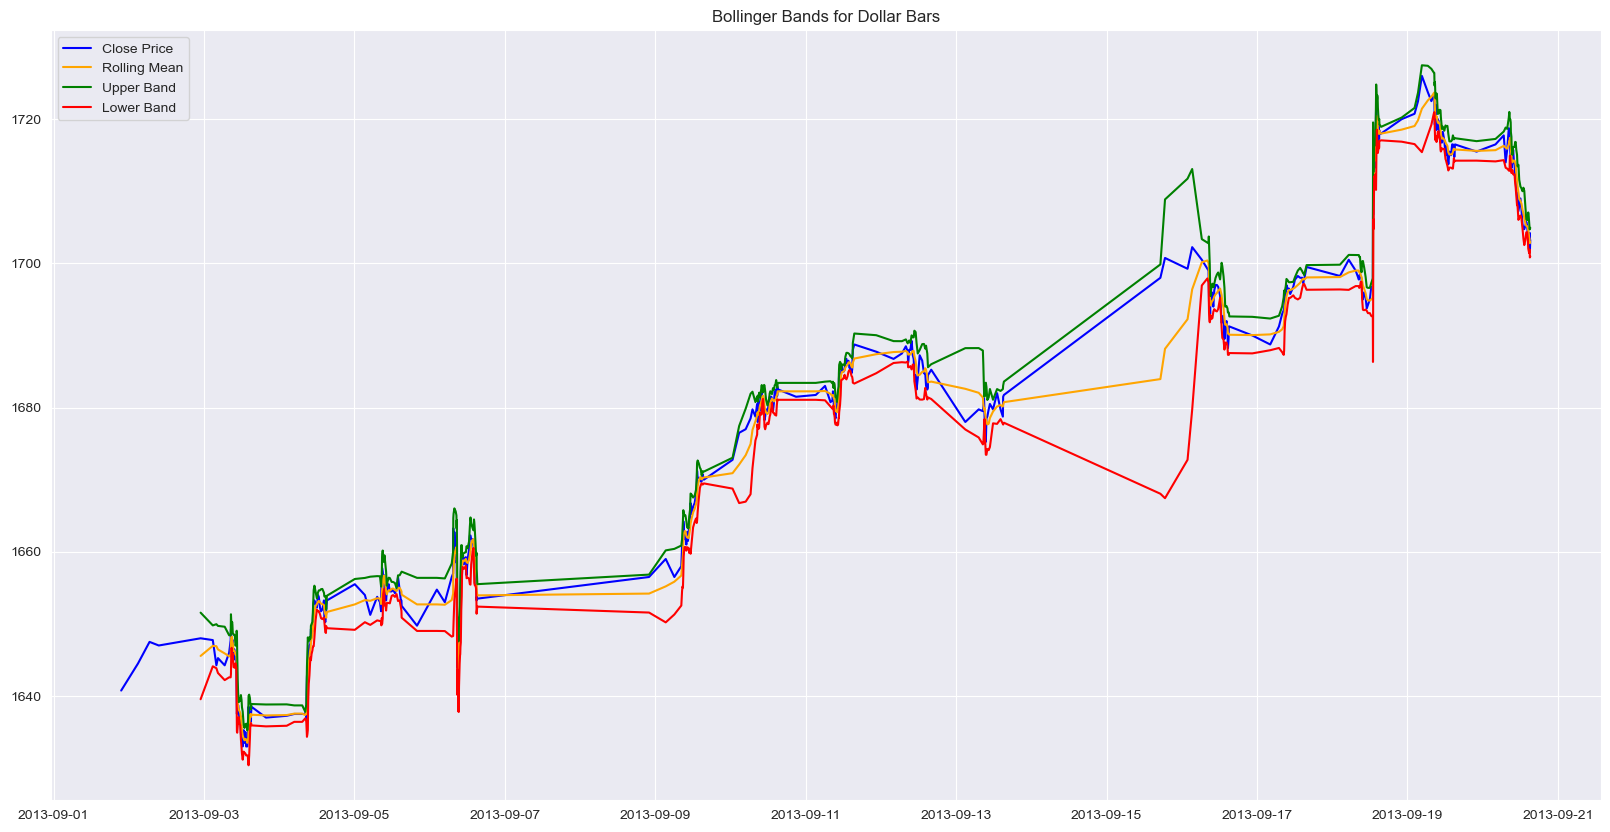

In [14]:
# plotting the Bollinger Bands for the dollar bars and dollar imbalance bars
plt.figure(figsize=(20, 10))
plt.plot(continuous_dollar_relative_method['close'], label='Close Price', color='blue')
plt.plot(rolling_mean_dollar, label='Rolling Mean', color='orange')
plt.plot(upper_band_dollar, label='Upper Band', color='green')
plt.plot(lower_band_dollar, label='Lower Band', color='red')
plt.title('Bollinger Bands for Dollar Bars')
plt.legend()
plt.show()


### CUSUM Filter Approach

In [15]:
from mlfinlab.filters.filters import cusum_filter as CUSUMFilter

# applying the CUSUM filter to dollar bars returns

# computing the returns for the dollar bars using pct change
dollar_returns = continuous_dollar_relative_method['close'].pct_change().dropna()

# computing the CUSUM filter for the dollar bars returns with a threshold of 0.05
cusum_filter = CUSUMFilter(dollar_returns, threshold=0.05)

# creating a dataframe with only the filtered values
filtered_dollar_returns = dollar_returns[cusum_filter]

# viewing the head of the filtered dollar returns
filtered_dollar_returns.head()


2013-09-02 06:37:33.128    0.001824
2013-09-03 08:33:05.939    0.000607
2013-09-03 08:36:23.346    0.000303
2013-09-03 09:11:04.690    0.000607
2013-09-03 13:59:58.999    0.001072
Name: close, dtype: float64

In [16]:

# priting the number of filtered samples
print('Number of filtered samples:', len(filtered_dollar_returns))
print('Number of unfiltered samples:', len(dollar_returns))
print('Percentage of filtered samples:', len(filtered_dollar_returns)/len(dollar_returns)*100)


Number of filtered samples: 149
Number of unfiltered samples: 519
Percentage of filtered samples: 28.709055876685934


### Testing Hetrokedasticity of the Dollar Bars and CUSUM Filtered Returns

In [19]:
# comparing the hetrokedasticity of the dollar bars and the CUSUM filtered returns.

# computing the rolling standard deviation  (n=5) of the dollar bars and the CUSUM filtered returns
dollar_std = dollar_returns.rolling(window=5).std().dropna()
filtered_std = filtered_dollar_returns.rolling(window=5).std().dropna()


# printing the average standard deviation of the dollar bars and the CUSUM filtered returns
print('Average Standard Deviation of Dollar Bars:', dollar_std.mean())
print('Average Standard Deviation of CUSUM Filtered Returns:', filtered_std.mean())


Average Standard Deviation of Dollar Bars: 0.0008813943349389562
Average Standard Deviation of CUSUM Filtered Returns: 0.0006555115684778403


In [18]:
# calculculating the hetrokedasticity of the dollar bars and the CUSUM filtered returns using the Levene test
levene_test = stats.levene(dollar_returns, filtered_dollar_returns)

# printing the results of the Levene test
print('Levene Test:', levene_test)

Levene Test: LeveneResult(statistic=11.910611626528475, pvalue=0.0005934171200912147)
